In [540]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos

In [541]:
def _to_num_time(s):
    return pd.to_numeric(str(s).strip().replace(',', '.'), errors='coerce')

def _to_num_counts(s):
    s = str(s).strip().replace('.', '').replace(',', '.')
    return pd.to_numeric(s, errors='coerce')

def _auto_scale_factor(series: pd.Series) -> float:
    med = pd.to_numeric(series, errors='coerce').median()
    return 1e-3 if pd.notna(med) and med > 1e6 else 1.0

def datos_cinetica(path_csv: str) -> pd.DataFrame:
    df = pd.read_csv(path_csv, sep=';').copy()
    for c in ['Time','I1','I2','GPolarization','Ratio','RatioStdError',
              'GPolarizationStdError','I1StdError','I2StdError','RealTime','RealTemperature']:
        if c in df.columns:
            if c == 'Time':
                df[c] = df[c].map(_to_num_time)
            elif c in ['I1','I2','I1StdError','I2StdError']:
                df[c] = df[c].map(_to_num_counts)
            else:
                df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.'), errors='coerce')
    df = df.sort_values('Time')
    s1 = _auto_scale_factor(df.get('I1', pd.Series(dtype=float)))
    s2 = _auto_scale_factor(df.get('I2', pd.Series(dtype=float)))
    scale = max(s1, s2)
    df['I1_plot'] = df.get('I1') * scale
    df['I2_plot'] = df.get('I2') * scale
    df.attrs['scale_factor'] = scale
    return df

def datos_espectro(path_csv: str) -> pd.DataFrame:
    df = pd.read_csv(path_csv, sep=';').copy()
    if 'EmissionWavelength' in df.columns:
        df['EmissionWavelength'] = pd.to_numeric(df['EmissionWavelength'].astype(str).str.replace(',', '.'), errors='coerce')
    if 'Intensity' in df.columns:
        df['Intensity'] = pd.to_numeric(df['Intensity'].astype(str).str.replace('.', '').str.replace(',', '.'), errors='coerce')
    if 'IntensityStdError' in df.columns:
        df['IntensityStdError'] = pd.to_numeric(df['IntensityStdError'].astype(str).str.replace('.', '').str.replace(',', '.'), errors='coerce')
    return df.sort_values('EmissionWavelength')


**Datos**

In [542]:
cine1 = datos_cinetica("01 CCCP Dioc cinetica inicio.csv")




espec1_c = datos_espectro("01 Espectro con cccp.csv")
espec1_s = datos_espectro("01 Espectro sin cccp.csv")
espec2_s = datos_espectro("02 Espectro sin cccp.csv")


# Gráficas de cinética

In [543]:
def plot_cinetica(df, mode='raw', t_base=780.0,
                  label1='I1=500 nm', label2='I2=550 nm', title='Cinética',
                  color1=None, color2=None, ls1='-', ls2='--', mk1=None, mk2=None):
    df = df.dropna(subset=['Time']).copy()
    if 'I1_plot' not in df.columns and 'I1' in df.columns:
        scale = df.attrs.get('scale_factor', 1.0)
        df['I1_plot'] = df['I1'] * scale
        df['I2_plot'] = df['I2'] * scale

    if mode == 'twinx':
        fig, ax = plt.subplots()
        ax.plot(df['Time'], df['I1_plot'], label=label1)
        ax.set_xlabel('Tiempo (s)'); ax.set_ylabel('Intensidad I1')
        ax2 = ax.twinx()
        ax2.plot(df['Time'], df['I2_plot'], '--', label=label2)
        ax.grid(True); fig.legend(loc='upper right'); plt.title(title + ' (ejes Y separados)')
        plt.show(); return

    if mode == 'baseline':
        base = df['Time'] < t_base
        I1n = df['I1_plot'] / df.loc[base, 'I1_plot'].median()
        I2n = df['I2_plot'] / df.loc[base, 'I2_plot'].median()
        plt.figure()
        plt.plot(df['Time'], I1n, label=f'{label1}', color=color1, linestyle=ls1, marker=mk1)
        plt.plot(df['Time'], I2n, label=f'{label2}', color=color2, linestyle=ls2, marker=mk2)
        plt.xlabel('Tiempo (s)'); plt.ylabel('Intensidad normalizada')
        plt.title(title + ' normalizada'); plt.grid(True); plt.legend(); plt.show(); return

    if mode == 'align':
        base = df['Time'] < t_base
        mu1, mu2 = df.loc[base,'I1_plot'].median(), df.loc[base,'I2_plot'].median()
        s1 = df.loc[base,'I1_plot'].mad(); s2 = df.loc[base,'I2_plot'].mad()
        a = (s1/s2) if (pd.notna(s1) and pd.notna(s2) and s2) else 1.0
        b = mu1 - a*mu2
        I2_al = a*df['I2_plot'] + b
        plt.figure()
        plt.plot(df['Time'], df['I1_plot'], label=label1)
        plt.plot(df['Time'], I2_al, label=f'{label2} alineada (a={a:.3g}, b={b:.1f})')
        plt.xlabel('Tiempo (s)'); plt.ylabel('Intensidad (escala I1)')
        plt.title(title + ' — alineación lineal'); plt.grid(True); plt.legend(); plt.show(); return

    plt.figure()
    plt.scatter(df['Time'], df['I1_plot'], label=label1, color=color1, linestyle=ls1, marker=mk1)
    plt.scatter(df['Time'], df['I2_plot'], label=label2, color=color2, linestyle=ls2, marker=mk2)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    plt.ticklabel_format(axis='y', style='plain')
    plt.xlabel('Tiempo (s)'); plt.ylabel('Intensidad'); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

def plot_espectro(df_spec: pd.DataFrame, title='Espectro'):
    plt.figure()
    plt.plot(df_spec['EmissionWavelength'], df_spec['Intensity'])
    plt.xlabel('Longitud de onda (nm)'); plt.ylabel('Intensidad')
    plt.title(title); plt.grid(True); plt.show()

Factor de escala aplicado: 0.001


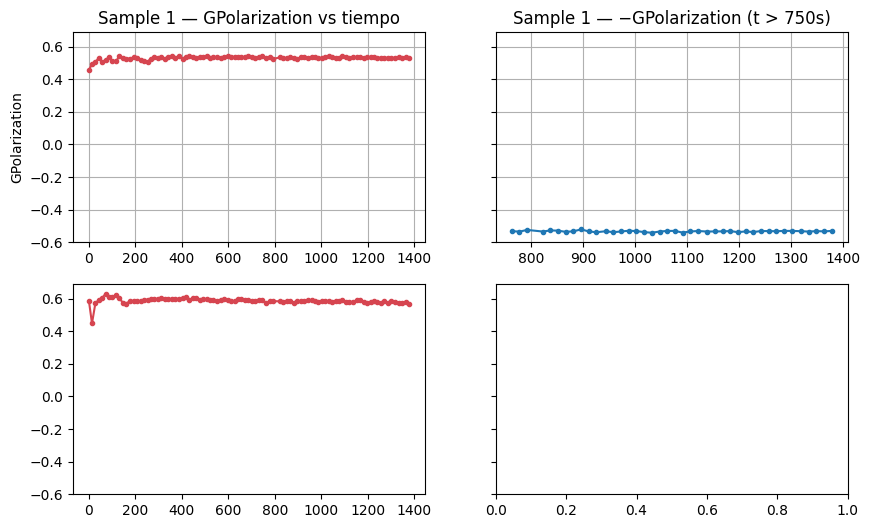

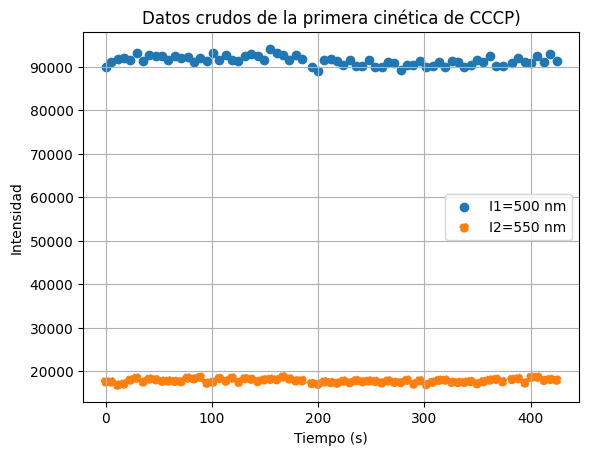

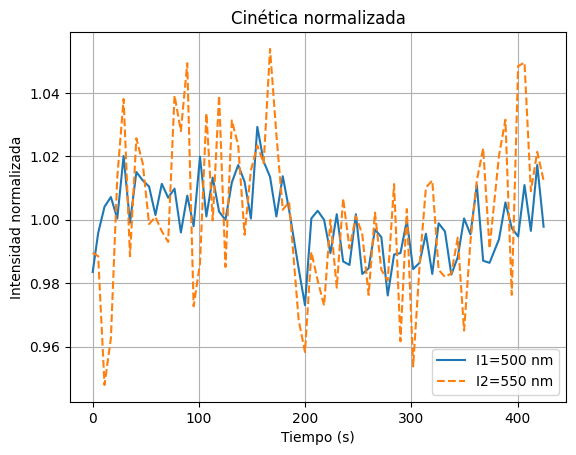

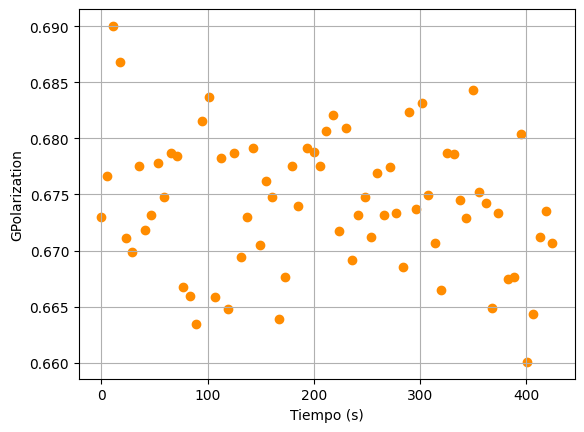

In [544]:
cine1 = datos_cinetica("01 CCCP Dioc cinetica inicio.csv")
print('Factor de escala aplicado:', cine1.attrs.get('scale_factor'))
plot_cinetica(cine1, mode='raw', title='Datos crudos de la primera cinética de CCCP)')
plot_cinetica(cine1, mode='baseline', title='Cinética')
#plot_cinetica(cine1, mode='align', title='Cinética')
#plot_cinetica(cine1, mode='twinx', title='Cinética')

plt.scatter(cine1["Time"], cine1["GPolarization"], marker='o', color='darkorange')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
#plt.legend()
plt.grid()
plt.show()

Teníamos la corriente al mínimo del fluorómetro ):

Factor de escala aplicado: 0.001


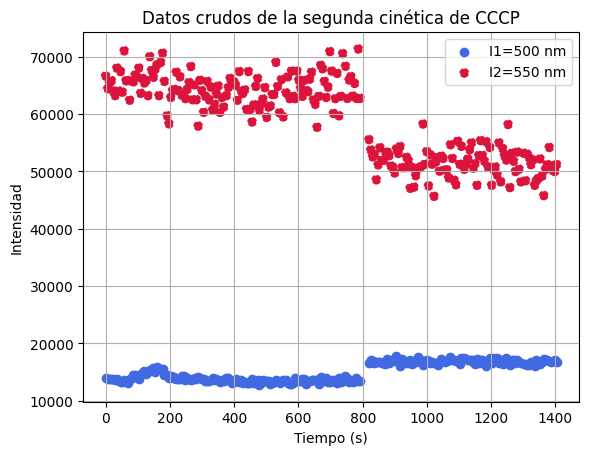

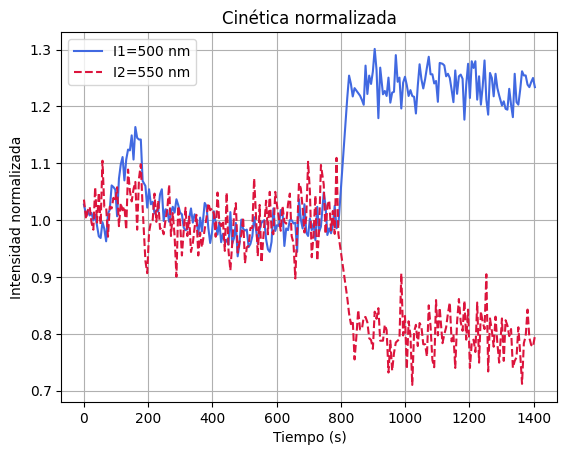

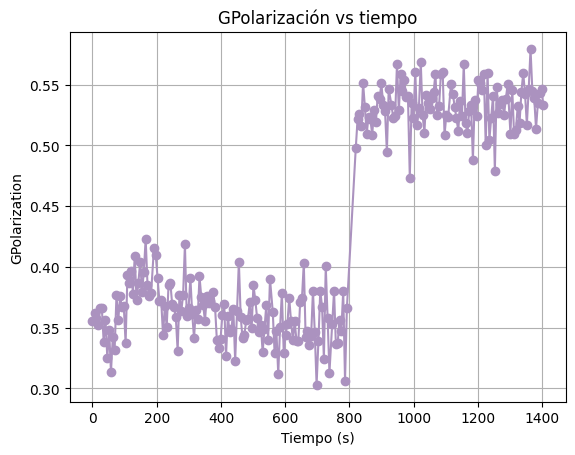

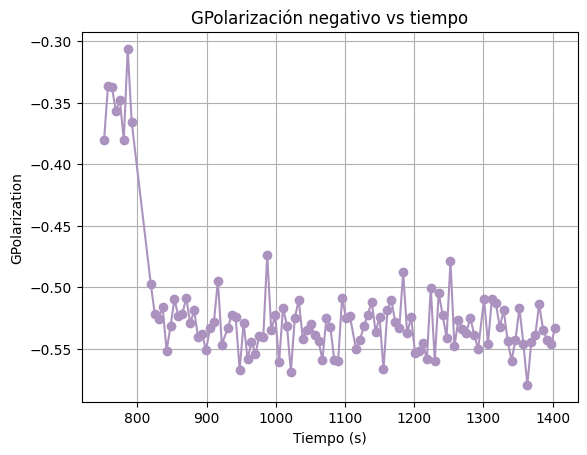

In [545]:
cine2 = datos_cinetica("01 CCCP Dioc cinetica_.csv")
print('Factor de escala aplicado:', cine2.attrs.get('scale_factor'))
plot_cinetica(cine2, mode='raw', title='Datos crudos de la segunda cinética de CCCP', color1='#4169e1', color2='#dc143c')
plot_cinetica(cine2, mode='baseline', title='Cinética',
              color1='#4169e1', color2='#dc143c')

#plot_cinetica(cine1, mode='align', title='Cinética')
#plot_cinetica(cine1, mode='twinx', title='Cinética')

plt.plot(cine2["Time"], cine2["GPolarization"], marker='o', color='#ab92bf')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización vs tiempo')
#plt.legend()
plt.grid()
plt.show()

cine2.index[cine2["Time"] > 750]
mayores_750 = cine2[cine2["Time"] > 750] #filtrado cccp

plt.plot(mayores_750["Time"], -mayores_750["GPolarization"], marker='o', color='#ab92bf')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización negativo vs tiempo')
#plt.legend()
plt.grid()
plt.show()

Se agrega una segunda malla y ya no se visualiza fotoblanqueo, pero sí ruido.
Se trabajó con todas las rendijas en 0.5

Factor de escala aplicado: 0.001


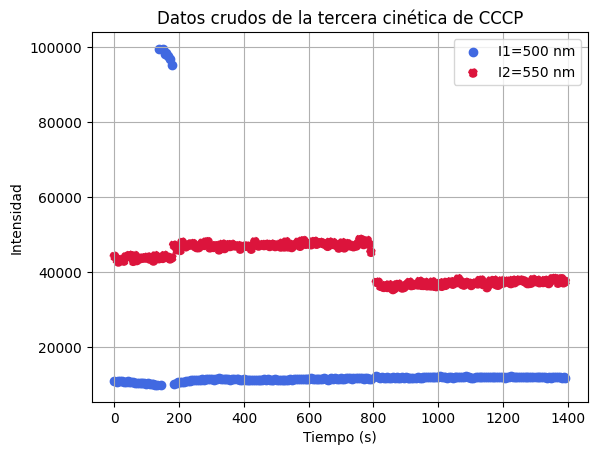

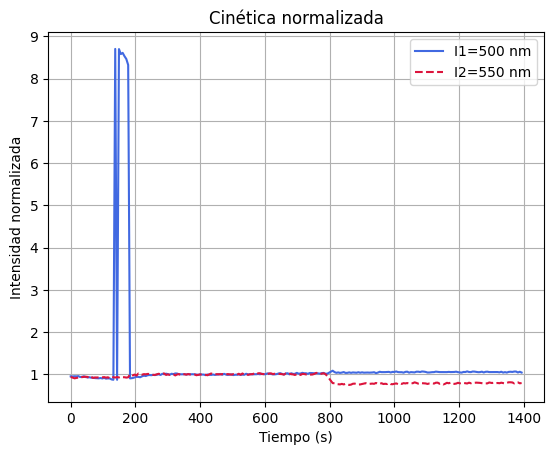

In [546]:
cine3 = datos_cinetica("03 CCCP Dioc cinetica.csv")
print('Factor de escala aplicado:', cine3.attrs.get('scale_factor'))
plot_cinetica(cine3, mode='raw', title='Datos crudos de la tercera cinética de CCCP', color1='#4169e1', color2='#dc143c')
plot_cinetica(cine3, mode='baseline', title='Cinética',
              color1='#4169e1', color2='#dc143c')

#plot_cinetica(cine1, mode='align', title='Cinética')
#plot_cinetica(cine1, mode='twinx', title='Cinética')

In [547]:
w = 5  # ventana impar
cine3["I1_smooth"] = cine3["I1_plot"].rolling(w, center=True, min_periods=1).mean()
cine3["I2_smooth"] = cine3["I2_plot"].rolling(w, center=True, min_periods=1).mean()


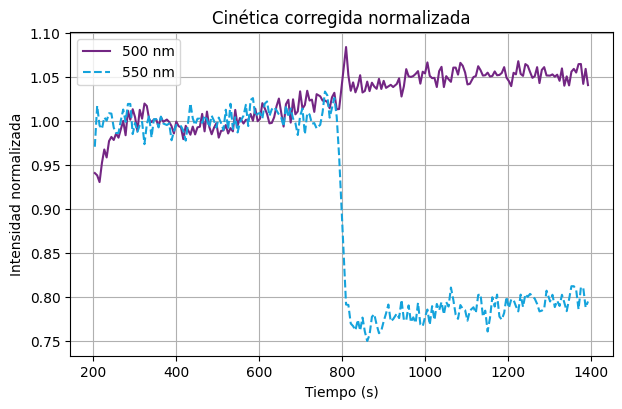

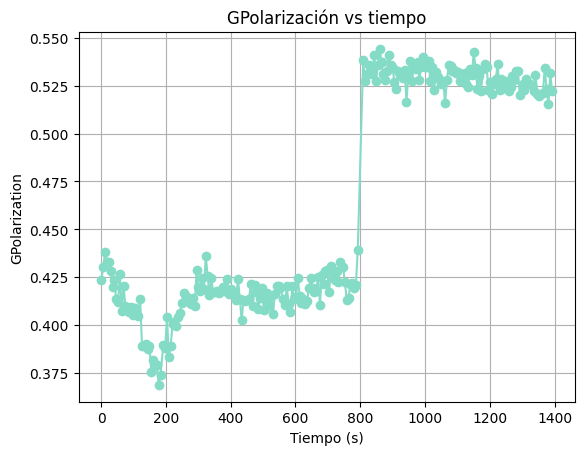

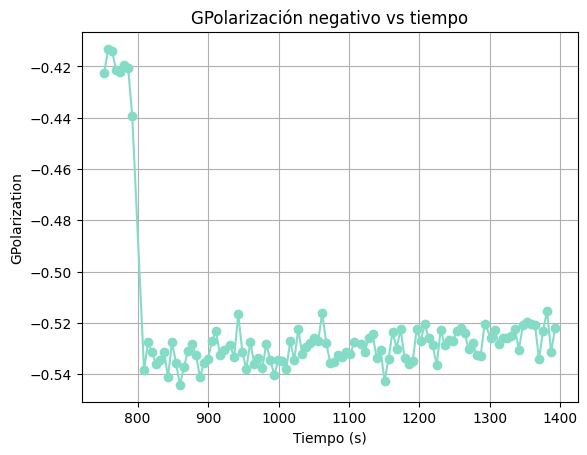

In [548]:
t0, t1 = 150, 780                     # <-- intervalo de baseline deseado
base = cine3["Time"].between(t0, t1)  # True solo en ese rango

I1n = cine3["I1_plot"] / cine3.loc[base, "I1_plot"].median()
I2n = cine3["I2_plot"] / cine3.loc[base, "I2_plot"].median()


g0, g1 = 200, 1400                      # <-- intervalo a mostrar en la gráfica
mask_plot = cine3["Time"].between(g0, g1)

plt.figure(figsize=(7,4.2))
plt.plot(cine3.loc[mask_plot, "Time"], I1n.loc[mask_plot], label="500 nm", color="#732683")
plt.plot(cine3.loc[mask_plot, "Time"], I2n.loc[mask_plot], label="550 nm", color="#14a3dc", linestyle="--")
plt.xlabel("Tiempo (s)"); plt.ylabel("Intensidad normalizada")
plt.title(f"Cinética corregida normalizada")
plt.grid(True); plt.legend(); plt.show()


plt.plot(cine3["Time"], cine3["GPolarization"], marker='o', color='#84dcc6')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización vs tiempo')
#plt.legend()
plt.grid()
plt.show()

cine3.index[cine3["Time"] > 750]
mayores_750 = cine3[cine3["Time"] > 750] #filtrado cccp

plt.plot(mayores_750["Time"], -mayores_750["GPolarization"], marker='o', color='#84dcc6')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización negativo vs tiempo')
#plt.legend()
plt.grid()
plt.show()

Se toma la gráfica a partir de 200 s porque antes hay problemas con los valores. Para este caso, se mantuvo la configuración de 2 mallas pero con rendijas de 1 para al frente del fluorómetro. Sigue habiendo ruido aunque ya no es tan presente como antes.

Factor de escala aplicado: 0.001


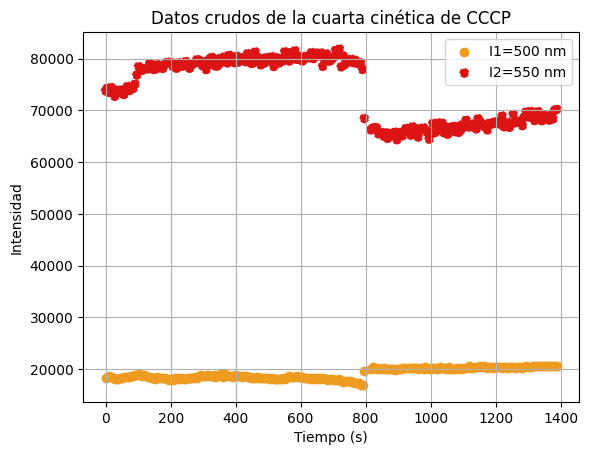

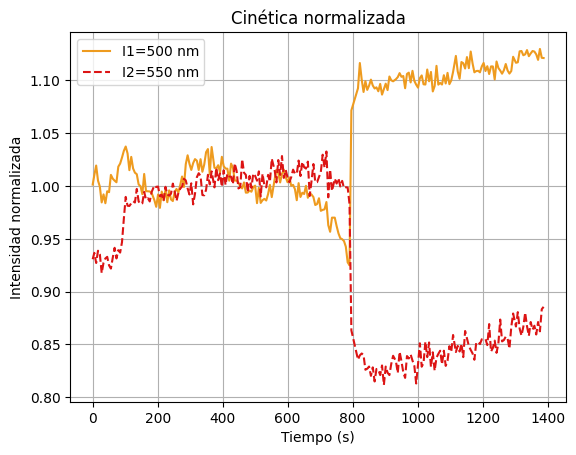

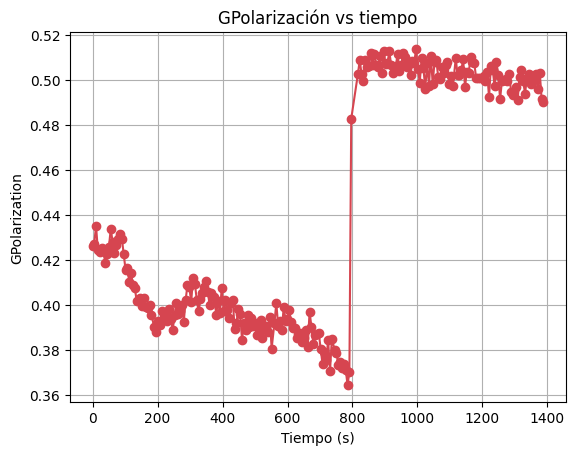

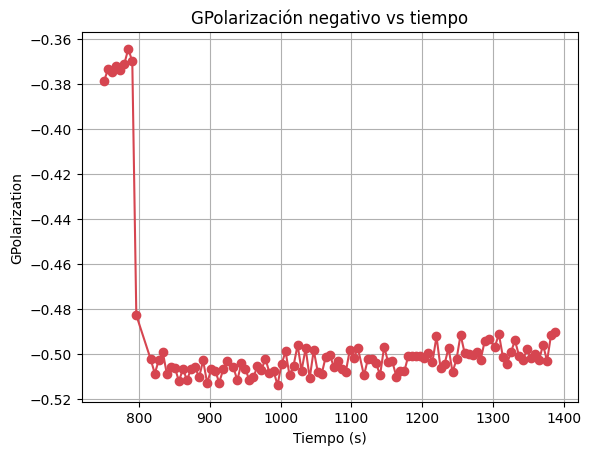

In [549]:
cine4 = datos_cinetica("04 CCCP Dioc cinetica.csv")
print('Factor de escala aplicado:', cine4.attrs.get('scale_factor'))
plot_cinetica(cine4, mode='raw', title='Datos crudos de la cuarta cinética de CCCP', color1="#ee9b1f", color2="#dc1414")
plot_cinetica(cine4, mode='baseline', title='Cinética',
              color1="#ee9b1f", color2="#dc1414")

plt.plot(cine4["Time"], cine4["GPolarization"], marker='o', color='#d64550')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización vs tiempo')
#plt.legend()
plt.grid()
plt.show()

cine4.index[cine4["Time"] > 750]
mayores_750 = cine4[cine4["Time"] > 750] #filtrado cccp

plt.plot(mayores_750["Time"], -mayores_750["GPolarization"], marker='o', color='#d64550')
plt.xlabel('Tiempo (s)') 
plt.ylabel('GPolarization')
plt.title('GPolarización negativo vs tiempo')
#plt.legend()
plt.grid()
plt.show()

#plot_cinetica(cine1, mode='align', title='Cinética')
#plot_cinetica(cine1, mode='twinx', title='Cinética')

Se mantiene la configuración de las dos mallas, pero se cambia otra rendija de 0.5 a 1 en la parte trasera del fluorómetro, en la parte después de donde ingresa la luz.

**Caso especial: Toma de datos 5**

filas sample1: 93 | filas sample2: 92
    Time          Sample          I1          I2
1   0.00          Sample  16882800.0  62908000.0
3  13.24          Sample  11930800.0  40508000.0
5  27.83          Sample  14988800.0  49208000.0
    Time          Sample          I1          I2
2   0.00         Sample2  16338800.0  42628000.0
4  13.24         Sample2  10492800.0  39988000.0
6  27.83         Sample2  13484800.0  36748000.0


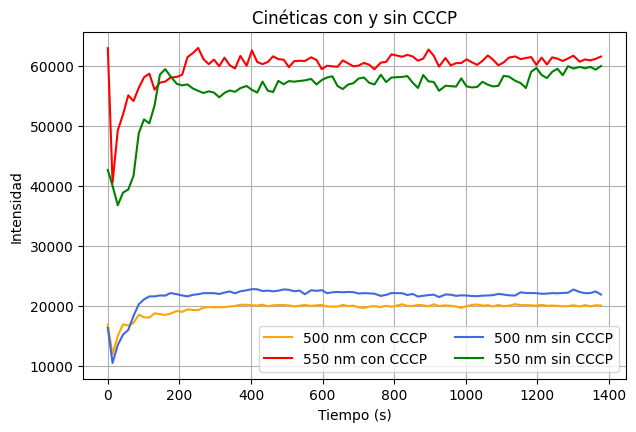

In [550]:
path = "05 con y sin CCCP cinetica (sin bacterias).csv"

# Lee TODO como texto para poder normalizar
raw = pd.read_csv(path, sep=";", engine="python", dtype=str, header=None)

# Asigna encabezados esperados (el archivo no trae header "real")
raw.columns = ['Time','Sample','Iteration','Ratio','GPolarization','I1','I2',
               'RatioStdError','GPolarizationStdError','I1StdError','I2StdError',
               'RealTime','RealTemperature']

# --- normalización numérica robusta ---
def to_time(s):
    return pd.to_numeric(str(s).strip().replace(",", "."), errors="coerce")

def to_counts(s):
    s = str(s).strip().replace(".", "").replace(",", ".")  # quita miles y usa punto decimal
    return pd.to_numeric(s, errors="coerce")

raw["Time"] = raw["Time"].map(to_time)
raw["I1"]   = raw["I1"].map(to_counts)
raw["I2"]   = raw["I2"].map(to_counts)

# limpia/estandariza Sample y ordena por tiempo
raw["Sample_std"] = raw["Sample"].astype(str).str.strip().str.lower()
raw = raw.sort_values("Time")

# separa por casilla (soporta 'sample' / 'sample1'; 'sample2', etc.)
mask1 = raw["Sample_std"].isin(["sample","sample1"])
mask2 = raw["Sample_std"].isin(["sample2","sample 2"])

sample1 = raw[mask1].copy()
sample2 = raw[mask2].copy()

print("filas sample1:", len(sample1), "| filas sample2:", len(sample2))
print(sample1[["Time","Sample","I1","I2"]].head(3))
print(sample2[["Time","Sample","I1","I2"]].head(3))

# escala tipo “equipo” (÷1000 si corresponde)
scale = 1e-3 if (raw["I1"].median() > 1e6 or raw["I2"].median() > 1e6) else 1.0
sample1["I1p"] = sample1["I1"] * scale
sample1["I2p"] = sample1["I2"] * scale
sample2["I1p"] = sample2["I1"] * scale
sample2["I2p"] = sample2["I2"] * scale

# grafica
plt.figure(figsize=(7,4.5))
plt.plot(sample1["Time"], sample1["I1p"], label="500 nm con CCCP", color="orange")
plt.plot(sample1["Time"], sample1["I2p"], label="550 nm con CCCP", color="red")
plt.plot(sample2["Time"], sample2["I1p"], label="500 nm sin CCCP", color="royalblue")
plt.plot(sample2["Time"], sample2["I2p"], label="550 nm sin CCCP", color="green")
plt.xlabel("Tiempo (s)"); plt.ylabel("Intensidad")
plt.title("Cinéticas con y sin CCCP")
plt.grid(True); plt.legend(ncol=2); plt.show()


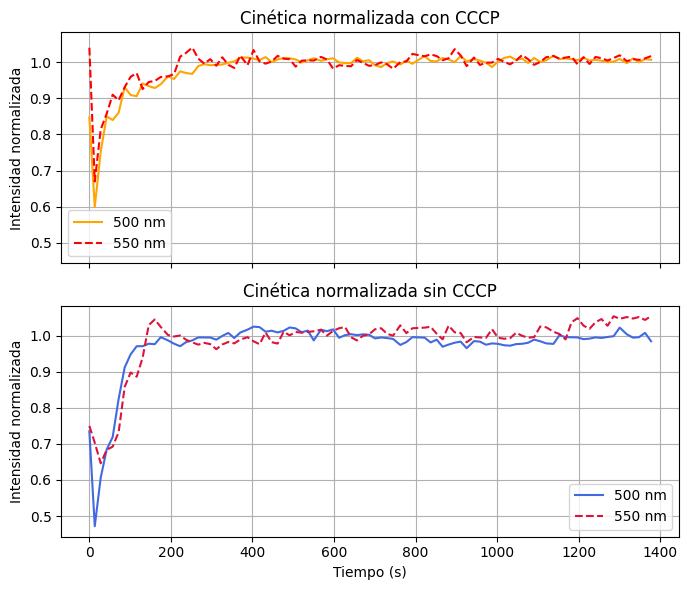

In [551]:
# --- Parámetros ---
t0, t1 = 150, 780      # intervalo de baseline (ajústalo)
smooth_win = 1         # 1 = sin suavizado; usa 3,5,7... para media móvil

def _choose_cols(df):
    # usa columnas escaladas si existen; si no, usa I1/I2 con autoescala tipo “equipo”
    if {"I1p","I2p"}.issubset(df.columns):
        y1, y2 = df["I1p"].to_numpy(), df["I2p"].to_numpy()
    else:
        scale = 1e-3 if (df["I1"].median() > 1e6 or df["I2"].median() > 1e6) else 1.0
        y1, y2 = (df["I1"]*scale).to_numpy(), (df["I2"]*scale).to_numpy()
    return df["Time"].to_numpy(), y1, y2

def _smooth(y, w):
    if w is None or w <= 1: 
        return y
    w = int(w) if int(w) % 2 == 1 else int(w) + 1  # ventana impar
    k = np.ones(w)/w
    return np.convolve(y, k, mode="same")

def _normalize_by_baseline(t, y, t0, t1):
    mask = (t >= t0) & (t <= t1)
    base = np.nanmedian(y[mask]) if mask.any() else np.nanmedian(y)
    return y / base

# --- Preparar datos de cada casilla ---
t1_s, y1_s1, y2_s1 = _choose_cols(sample1)
t2_s, y1_s2, y2_s2 = _choose_cols(sample2)

# Suavizado (opcional)
y1_s1 = _smooth(y1_s1, smooth_win); y2_s1 = _smooth(y2_s1, smooth_win)
y1_s2 = _smooth(y1_s2, smooth_win); y2_s2 = _smooth(y2_s2, smooth_win)

# Normalización por baseline (independiente por casilla)
Y1n_s1 = _normalize_by_baseline(t1_s, y1_s1, t0, t1)
Y2n_s1 = _normalize_by_baseline(t1_s, y2_s1, t0, t1)
Y1n_s2 = _normalize_by_baseline(t2_s, y1_s2, t0, t1)
Y2n_s2 = _normalize_by_baseline(t2_s, y2_s2, t0, t1)

# --- Plot en subplots (comparten ejes para comparar) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True, sharey=True)

ax1.plot(t1_s, Y1n_s1, color="orange", label="500 nm")
ax1.plot(t1_s, Y2n_s1, color="red", linestyle="--", label="550 nm")
ax1.set_title("Cinética normalizada con CCCP")
ax1.set_ylabel("Intensidad normalizada")
ax1.grid(True); ax1.legend()

ax2.plot(t2_s, Y1n_s2, color="royalblue", label="500 nm")
ax2.plot(t2_s, Y2n_s2, color="crimson", linestyle="--", label="550 nm")
ax2.set_title("Cinética normalizada sin CCCP")
ax2.set_xlabel("Tiempo (s)")
ax2.set_ylabel("Intensidad normalizada")
ax2.grid(True); ax2.legend()

plt.tight_layout()
plt.show()


Se mantuvo la configuración de rejillas y rendijas                                                                             

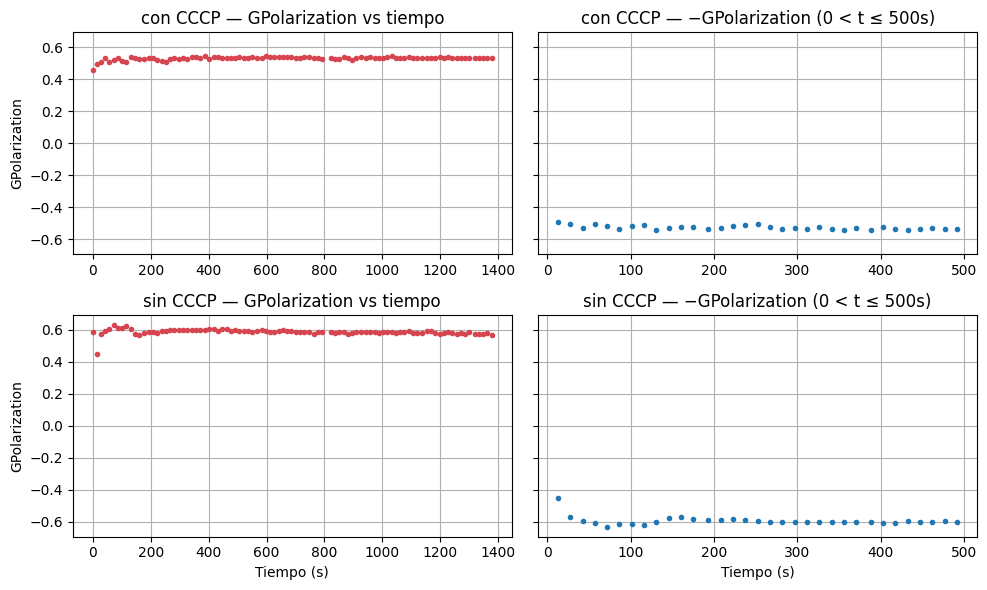

In [567]:
def _to_float(x):
    return pd.to_numeric(str(x).strip().replace(',', '.'), errors='coerce')

# Asegura columnas numéricas
for df in (sample1, sample2):
    df["GP"] = df["GPolarization"].map(_to_float)
    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")

# Parámetros de recorte del rango de tiempo
t_thr = 0
_max = 1400
_max_2  = 500

# Máscaras (método 1): filtra ANTES de graficar
m1_all = (sample1["Time"] >= t_thr) & (sample1["Time"] <= _max)
m1_neg = (sample1["Time"] >  t_thr) & (sample1["Time"] <= _max_2)

m2_all = (sample2["Time"] >= t_thr) & (sample2["Time"] <= _max)
m2_neg = (sample2["Time"] >  t_thr) & (sample2["Time"] <= _max_2)

# 2×2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=False, sharey=True)

# con CCCP (Sample 1)
ax = axes[0,0]
ax.plot(sample1.loc[m1_all, "Time"], sample1.loc[m1_all, "GP"],
        "o", ms=3, color="#d64550")
ax.set_title("con CCCP — GPolarization vs tiempo")
ax.set_ylabel("GPolarization"); ax.grid(True)

ax = axes[0,1]
ax.plot(sample1.loc[m1_neg, "Time"], -sample1.loc[m1_neg, "GP"],
        "o", ms=3, color="#1f77b4")
ax.set_title(f"con CCCP — −GPolarization ({t_thr} < t ≤ {_max_2}s)")
ax.grid(True)

# sin CCCP (Sample 2)
ax = axes[1,0]
ax.plot(sample2.loc[m2_all, "Time"], sample2.loc[m2_all, "GP"],
        "o", ms=3, color="#d64550")
ax.set_title("sin CCCP — GPolarization vs tiempo")
ax.set_xlabel("Tiempo (s)"); ax.set_ylabel("GPolarization"); ax.grid(True)

ax = axes[1,1]
ax.plot(sample2.loc[m2_neg, "Time"], -sample2.loc[m2_neg, "GP"],
        "o", ms=3, color="#1f77b4")
ax.set_title(f"sin CCCP — −GPolarization ({t_thr} < t ≤ {_max_2}s)")
ax.set_xlabel("Tiempo (s)"); ax.grid(True)

plt.tight_layout()
plt.show()
